# Machine Learning Model

This notebook creates a baseline model to predict upset situations (when favorites lose) in football matches. The model uses opening and closing odds to make predictions via logistic regression.

## 1. Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Tuple

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, accuracy_score, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Configuration Settings

Define the required parameters for the model:
- `heavy_fav_threshold_odds`: Odds threshold for heavy favorites (1.40)
- `sample_size`: Sample size for quick testing (20000)
- `random_state`: Seed for reproducibility

In [2]:
@dataclass
class Config:
    opening_csv: str = \
        "/Users/boraberkercansever/Desktop/DSA210/processed/average_opening_odds_group1.csv"
    closing_csv: str = \
        "/Users/boraberkercansever/Desktop/DSA210/processed/average_closing_odds_group1.csv"
    heavy_fav_threshold_odds: float = 1.40
    sample_size: int | None = None  # limit rows for quick baseline run
    random_state: int = 42

## 3. Helper Functions

### 3.1 Calculating Implied Probabilities

Calculates implied probabilities and overround values from betting odds.

In [3]:
def implied_probs(odds_h: pd.Series, odds_d: pd.Series, odds_a: pd.Series) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    # Raw implied probabilities
    pH_raw = 1.0 / odds_h
    pD_raw = 1.0 / odds_d
    pA_raw = 1.0 / odds_a
    s = pH_raw + pD_raw + pA_raw
    # Overround = sum(raw) - 1
    overround = s - 1.0
    # Normalize to sum=1
    pH = pH_raw / s
    pD = pD_raw / s
    pA = pA_raw / s
    return pH, pD, pA, overround

### 3.2 Determining the Favorite Team

In [4]:
def pick_favorite_side(pH: pd.Series, pA: pd.Series) -> pd.Series:
    """Favorite side among teams (ignore draw). Returns 'H' or 'A'."""
    return np.where(pH >= pA, 'H', 'A')


def favorite_odds_from_side(side: pd.Series, odds_h: pd.Series, odds_a: pd.Series) -> pd.Series:
    """Return odds for the favorite side (H/A)."""
    return np.where(side == 'H', odds_h, odds_a)

## 4. Building the Dataset

Main function that merges opening and closing odds data and calculates features.

In [5]:
def build_dataset(cfg: Config) -> pd.DataFrame:
    # Load opening and closing CSVs
    df_open = pd.read_csv(cfg.opening_csv)
    df_close = pd.read_csv(cfg.closing_csv)

    # Ensure expected columns exist
    required_open_cols = {"HomeTeam", "AwayTeam", "Date", "league", "FTR", "AVG_H", "AVG_D", "AVG_A"}
    required_close_cols = {"HomeTeam", "AwayTeam", "Date", "league", "AVG_H_Close", "AVG_D_Close", "AVG_A_Close"}
    if not required_open_cols.issubset(df_open.columns):
        missing = required_open_cols.difference(df_open.columns)
        raise ValueError(f"Opening CSV missing columns: {missing}")
    if not required_close_cols.issubset(df_close.columns):
        missing = required_close_cols.difference(df_close.columns)
        raise ValueError(f"Closing CSV missing columns: {missing}")

    # Merge on keys
    keys = ["HomeTeam", "AwayTeam", "Date", "league"]
    df = pd.merge(df_open, df_close, on=keys, how='inner')

    # Drop rows with obvious missing odds
    df = df.dropna(subset=["AVG_H", "AVG_D", "AVG_A", "AVG_H_Close", "AVG_D_Close", "AVG_A_Close", "FTR"])\
           .copy()

    # Opening implied probabilities and overround
    pH_open, pD_open, pA_open, over_open = implied_probs(df["AVG_H"], df["AVG_D"], df["AVG_A"]) 
    # Closing implied probabilities and overround
    pH_close, pD_close, pA_close, over_close = implied_probs(df["AVG_H_Close"], df["AVG_D_Close"], df["AVG_A_Close"]) 

    # Favorite side by opening implied prob
    fav_side = pick_favorite_side(pH_open, pA_open)

    # Favorite opening/closing implied prob
    pFav_open = np.where(fav_side == 'H', pH_open, pA_open)
    pFav_close = np.where(fav_side == 'H', pH_close, pA_close)

    # Favorite opening odds
    fav_odds_open = favorite_odds_from_side(fav_side, df["AVG_H"], df["AVG_A"]).astype(float)

    # Heavy favorite filter
    heavy_mask = fav_odds_open < cfg.heavy_fav_threshold_odds
    df_heavy = df[heavy_mask].copy()

    # Recompute probabilities for heavy subset (align lengths)
    pH_open_h = pH_open[heavy_mask]
    pD_open_h = pD_open[heavy_mask]
    pA_open_h = pA_open[heavy_mask]
    over_open_h = over_open[heavy_mask]

    pH_close_h = pH_close[heavy_mask]
    pD_close_h = pD_close[heavy_mask]
    pA_close_h = pA_close[heavy_mask]
    over_close_h = over_close[heavy_mask]

    fav_side_h = fav_side[heavy_mask]
    pFav_open_h = pFav_open[heavy_mask]
    pFav_close_h = pFav_close[heavy_mask]

    # Label: favorite win?
    ftr = df_heavy["FTR"].astype(str)
    y = np.where((fav_side_h == 'H') & (ftr == 'H'), 1,
                 np.where((fav_side_h == 'A') & (ftr == 'A'), 1, 0))

    # Features (minimal): opening/closing favorite prob, delta, overrounds
    X = pd.DataFrame({
        "pFav_open": pFav_open_h,
        "pFav_close": pFav_close_h,
        "delta_pFav": pFav_close_h - pFav_open_h,
        "overround_open": over_open_h,
        "overround_close": over_close_h,
    })

    # Include simple context as dummies (league short code from league string)
    # Extract league code prefix (e.g., 'England' -> 'ENG') crude mapping
    league = df_heavy["league"].astype(str)
    league_code = league.str.split(':').str[0].str.strip().str.upper()
    league_dummies = pd.get_dummies(league_code, prefix="lg", drop_first=True)

    X = pd.concat([X.reset_index(drop=True), league_dummies.reset_index(drop=True)], axis=1)

    # Optional sampling for speed
    if cfg.sample_size is not None and len(X) > cfg.sample_size:
        rng = np.random.default_rng(cfg.random_state)
        idx = rng.choice(len(X), size=cfg.sample_size, replace=False)
        X = X.iloc[idx].reset_index(drop=True)
        y = y[idx]
        df_heavy = df_heavy.iloc[idx].reset_index(drop=True)

    return X, y, df_heavy

## 5. Model Training and Evaluation

Function that trains the Logistic Regression model and evaluates it on the test set.
Returns both metrics and the trained model with predictions for visualization.

In [ ]:
def train_and_eval(X: pd.DataFrame, y: np.ndarray, cfg: Config) -> tuple:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=cfg.random_state, stratify=y
    )

    model = LogisticRegression(
        penalty='l2', solver='liblinear', class_weight='balanced', random_state=cfg.random_state
    )
    model.fit(X_train, y_train)

    proba_test = model.predict_proba(X_test)[:, 1]
    pred_test = (proba_test >= 0.5).astype(int)

    metrics = {
        "n_train": int(len(X_train)),
        "n_test": int(len(X_test)),
        "auc": float(roc_auc_score(y_test, proba_test)),
        "brier": float(brier_score_loss(y_test, proba_test)),
        "accuracy": float(accuracy_score(y_test, pred_test)),
        "class_rate_test": float(y_test.mean()),
        "coef": dict(zip(X.columns.tolist(), model.coef_[0].tolist())),
    }
    
    # Return metrics, model, and test data for visualizations
    return metrics, model, X_test, y_test, proba_test, pred_test

## 6. Main Workflow

Main code block that executes all steps sequentially.

In [7]:
# Create configuration
cfg = Config(
    opening_csv=os.environ.get("OPENING_CSV", Config.opening_csv),
    closing_csv=os.environ.get("CLOSING_CSV", Config.closing_csv),
    heavy_fav_threshold_odds=float(os.environ.get("HEAVY_FAV_THRESHOLD", Config.heavy_fav_threshold_odds)),
    sample_size=int(os.environ.get("SAMPLE_SIZE", Config.sample_size)) if os.environ.get("SAMPLE_SIZE") else Config.sample_size,
    random_state=int(os.environ.get("SEED", Config.random_state)),
)

print("Building dataset…")
X, y, df_meta = build_dataset(cfg)
print(f"Dataset built: X={X.shape}, positives={y.sum()}, rate={y.mean():.3f}")

Building dataset…
Dataset built: X=(811, 9), positives=645, rate=0.795


In [ ]:
print("Training baseline logistic regression…")
metrics, model, X_test, y_test, proba_test, pred_test = train_and_eval(X, y, cfg)

# Display results
print("\nBaseline results:")
for k, v in metrics.items():
    print(f"  {k}: {v}")

Training baseline logistic regression…

Baseline results:
  n_train: 608
  n_test: 203
  auc: 0.5814847678201716
  brier: 0.23992821767719152
  accuracy: 0.6699507389162561
  class_rate_test: 0.7931034482758621
  coef: {'pFav_open': 0.9877250507150777, 'pFav_close': 1.1120539887892025, 'delta_pFav': 0.12432893807420561, 'overround_open': -0.12595136456631084, 'overround_close': -0.08089640170829468, 'lg_FRANCE': -0.1654387610996359, 'lg_GERMANY': 0.2975276749774047, 'lg_ITALY': -0.6240082282271198, 'lg_SPAIN': 0.05491759937341138}


/Users/boraberkercansever/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## 7. Model Visualizations

Let's visualize the model performance and results.

### 7.1 Feature Distributions

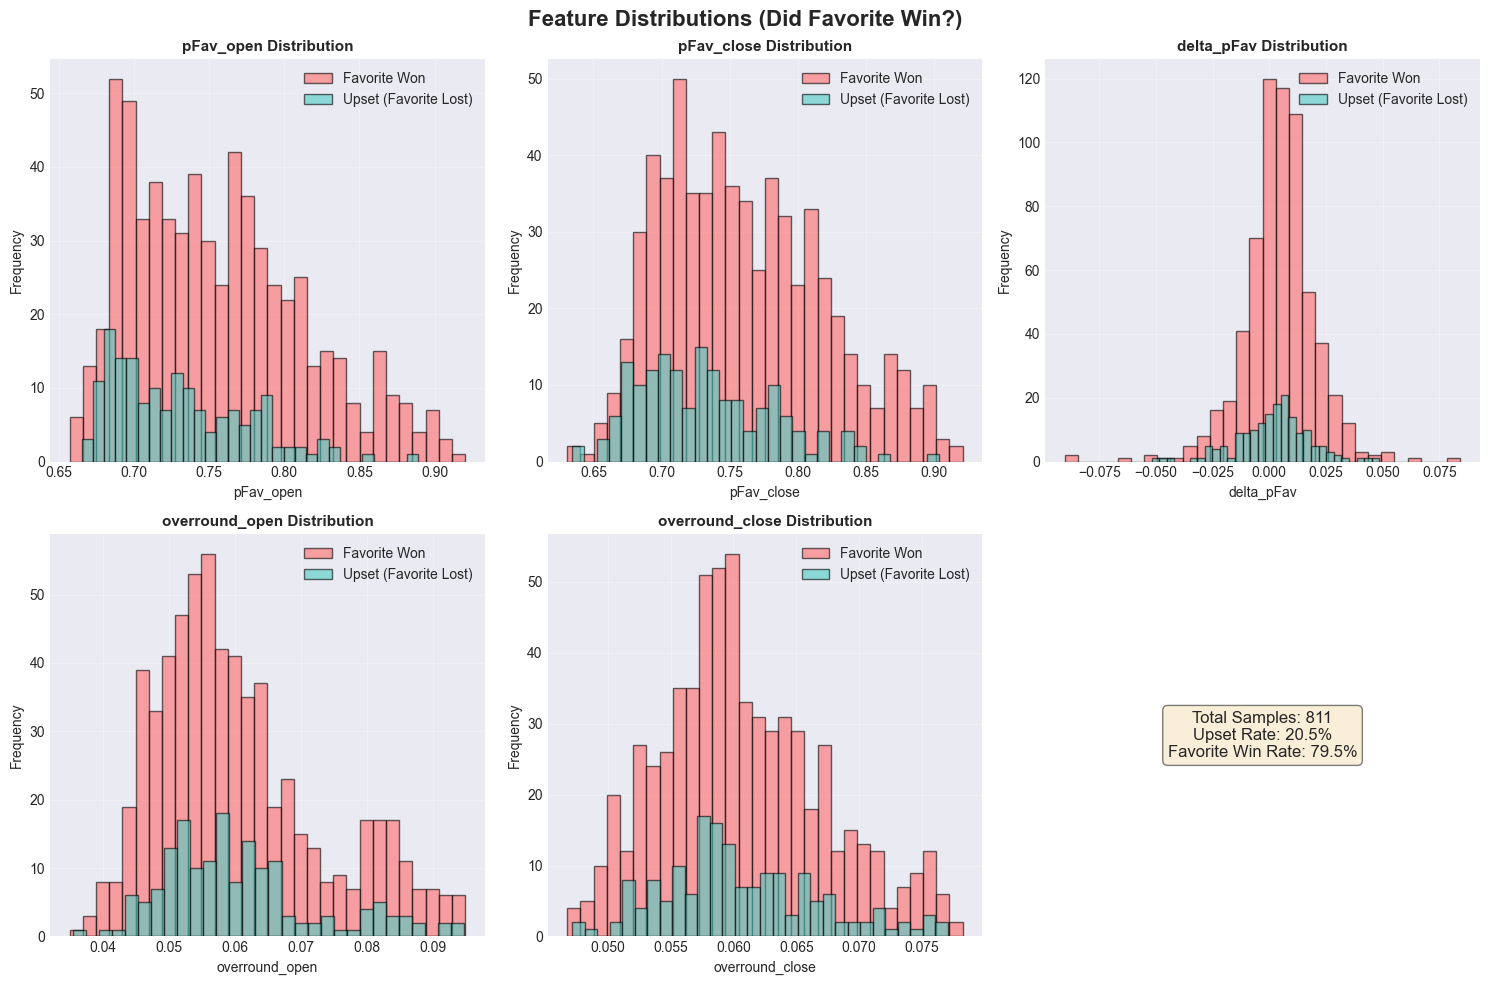

In [9]:
# Visualize the distribution of main features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distributions (Did Favorite Win?)', fontsize=16, fontweight='bold')

features_to_plot = ['pFav_open', 'pFav_close', 'delta_pFav', 'overround_open', 'overround_close']
colors = ['#FF6B6B', '#4ECDC4']

for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Separate histograms for when favorite won and when upset occurred
    ax.hist(X[y == 1][feature], bins=30, alpha=0.6, label='Favorite Won', color=colors[0], edgecolor='black')
    ax.hist(X[y == 0][feature], bins=30, alpha=0.6, label='Upset (Favorite Lost)', color=colors[1], edgecolor='black')
    
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Leave last subplot empty or add general statistics
axes[1, 2].axis('off')
axes[1, 2].text(0.5, 0.5, f'Total Samples: {len(X)}\nUpset Rate: {(1-y.mean())*100:.1f}%\nFavorite Win Rate: {y.mean()*100:.1f}%', 
                ha='center', va='center', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### 7.2 Correlation Heatmap

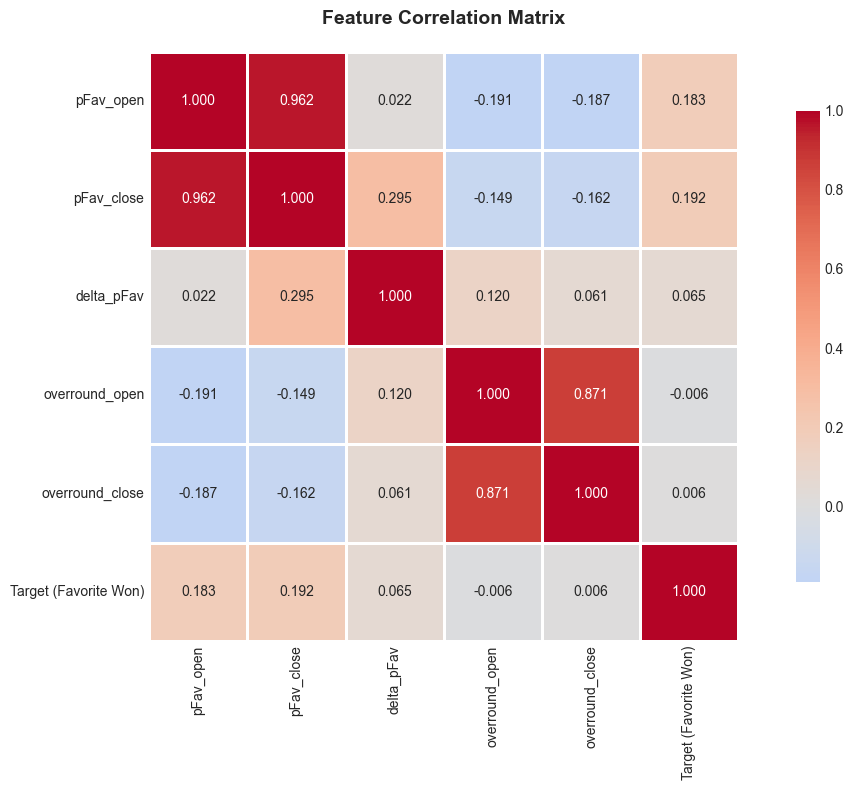

In [10]:
# Visualize correlation between features
plt.figure(figsize=(12, 8))

# Select only numeric features (excluding league dummies)
numeric_features = ['pFav_open', 'pFav_close', 'delta_pFav', 'overround_open', 'overround_close']
X_numeric = X[numeric_features].copy()
X_numeric['Target (Favorite Won)'] = y

# Correlation matrix
correlation_matrix = X_numeric.corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 7.3 Model Performance Metrics Visualization

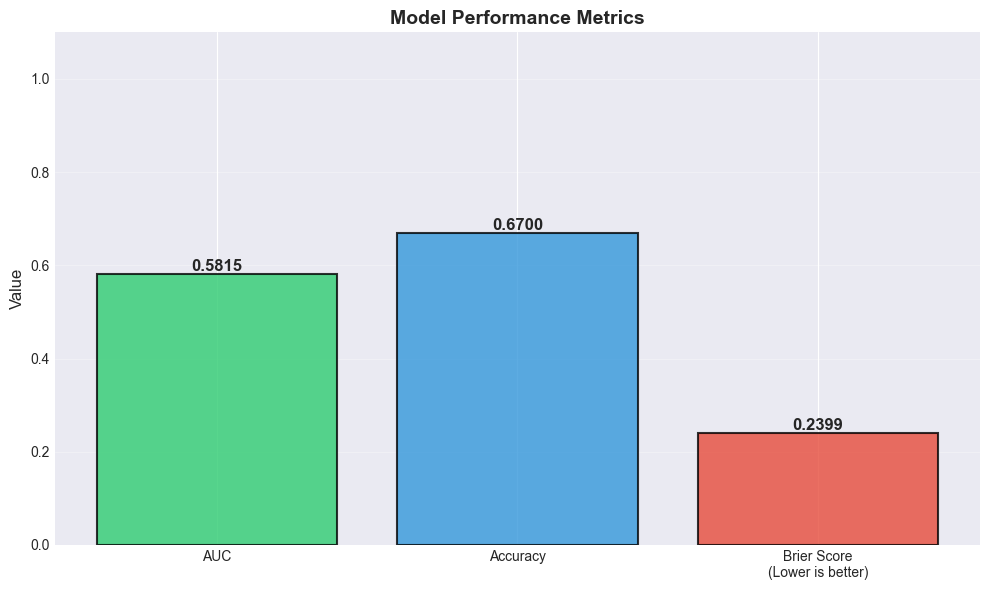

In [11]:
# Display model metrics with bar chart
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = ['AUC', 'Accuracy', 'Brier Score\n(Lower is better)']
metric_values = [metrics['auc'], metrics['accuracy'], metrics['brier']]
colors_bar = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax.bar(metric_names, metric_values, color=colors_bar, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add values on top of bars
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Value', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 7.4 Feature Importance (Model Coefficients)

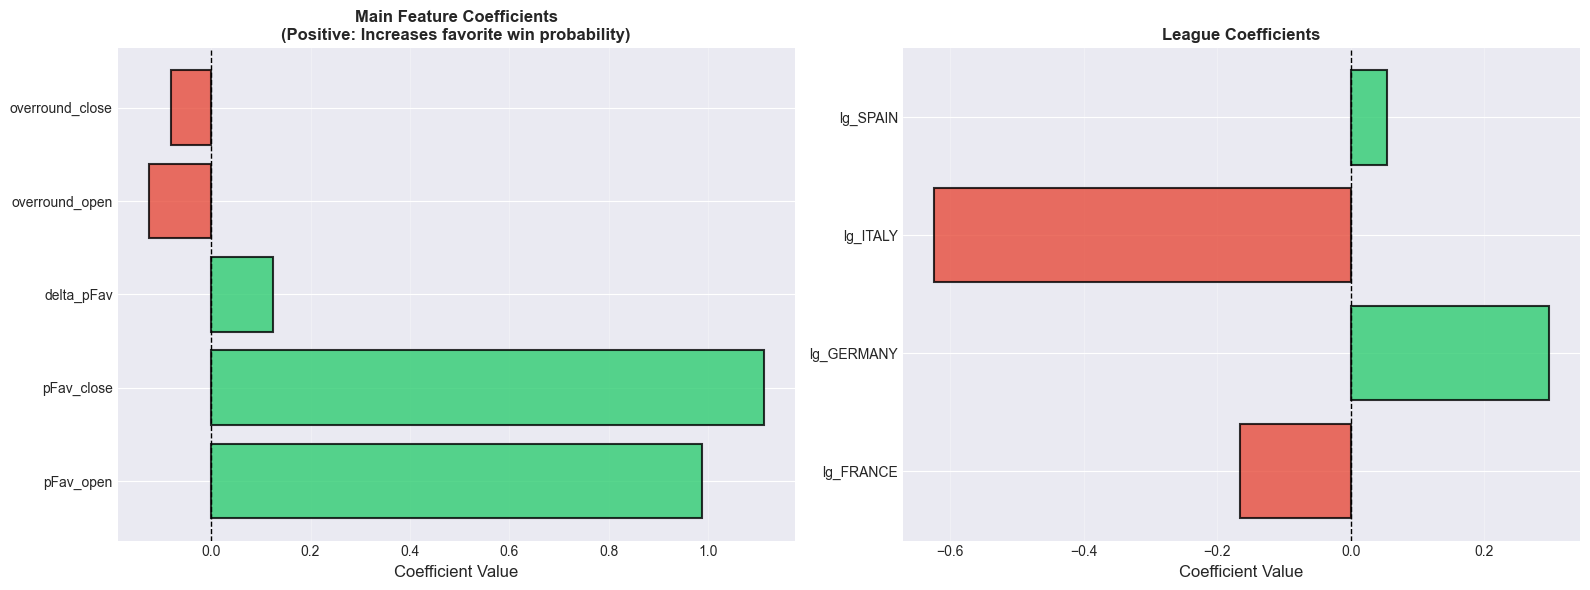

In [12]:
# Visualize model coefficients (feature importance)
coef_dict = metrics['coef']

# Show only main features (filter out league dummies)
main_features = {k: v for k, v in coef_dict.items() if not k.startswith('lg_')}
league_features = {k: v for k, v in coef_dict.items() if k.startswith('lg_')}

# Plot for main features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Main features
features = list(main_features.keys())
coefficients = list(main_features.values())
colors_coef = ['#e74c3c' if c < 0 else '#2ecc71' for c in coefficients]

ax1.barh(features, coefficients, color=colors_coef, edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Coefficient Value', fontsize=12)
ax1.set_title('Main Feature Coefficients\n(Positive: Increases favorite win probability)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Right panel: League features (if any)
if league_features:
    league_names = list(league_features.keys())
    league_coefs = list(league_features.values())
    colors_league = ['#e74c3c' if c < 0 else '#2ecc71' for c in league_coefs]
    
    ax2.barh(league_names, league_coefs, color=colors_league, edgecolor='black', linewidth=1.5, alpha=0.8)
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Coefficient Value', fontsize=12)
    ax2.set_title('League Coefficients', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
else:
    ax2.text(0.5, 0.5, 'No league information', ha='center', va='center', fontsize=12)
    ax2.axis('off')

plt.tight_layout()
plt.show()

### 7.5 Confusion Matrix and ROC Curve

Confusion matrix and ROC curve for detailed examination of model predictions.

/Users/boraberkercansever/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


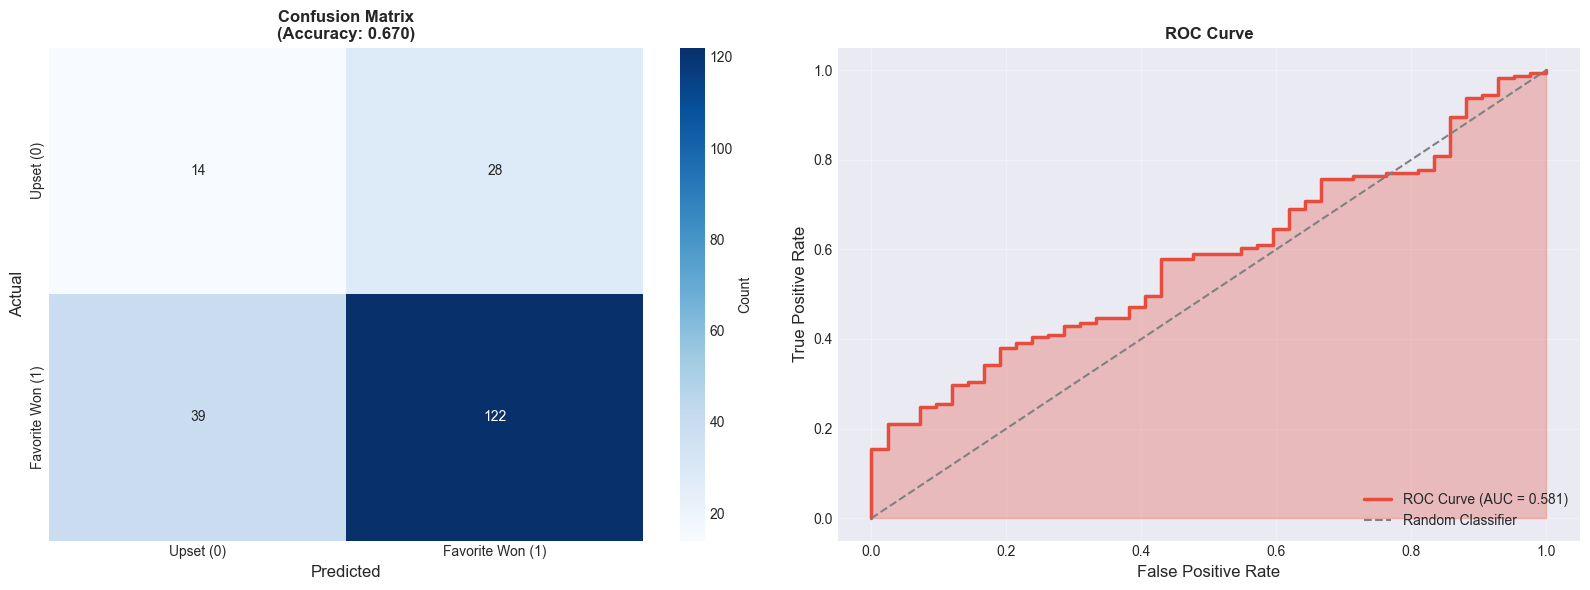


Confusion Matrix Details:
True Negatives (Correct Upset Prediction): 14
False Positives (Wrong Favorite Prediction): 28
False Negatives (Wrong Upset Prediction): 39
True Positives (Correct Favorite Prediction): 122


In [ ]:
# Use predictions from trained model (no need to retrain)
# Confusion Matrix and ROC Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'},
            xticklabels=['Upset (0)', 'Favorite Won (1)'],
            yticklabels=['Upset (0)', 'Favorite Won (1)'])
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_title(f'Confusion Matrix\n(Accuracy: {metrics["accuracy"]:.3f})', fontsize=12, fontweight='bold')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba_test)
ax2.plot(fpr, tpr, color='#e74c3c', linewidth=2.5, label=f'ROC Curve (AUC = {metrics["auc"]:.3f})')
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1.5, label='Random Classifier')
ax2.fill_between(fpr, tpr, alpha=0.3, color='#e74c3c')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Details:")
print(f"True Negatives (Correct Upset Prediction): {cm[0,0]}")
print(f"False Positives (Wrong Favorite Prediction): {cm[0,1]}")
print(f"False Negatives (Wrong Upset Prediction): {cm[1,0]}")
print(f"True Positives (Correct Favorite Prediction): {cm[1,1]}")

### 7.6 Prediction Probability Distribution

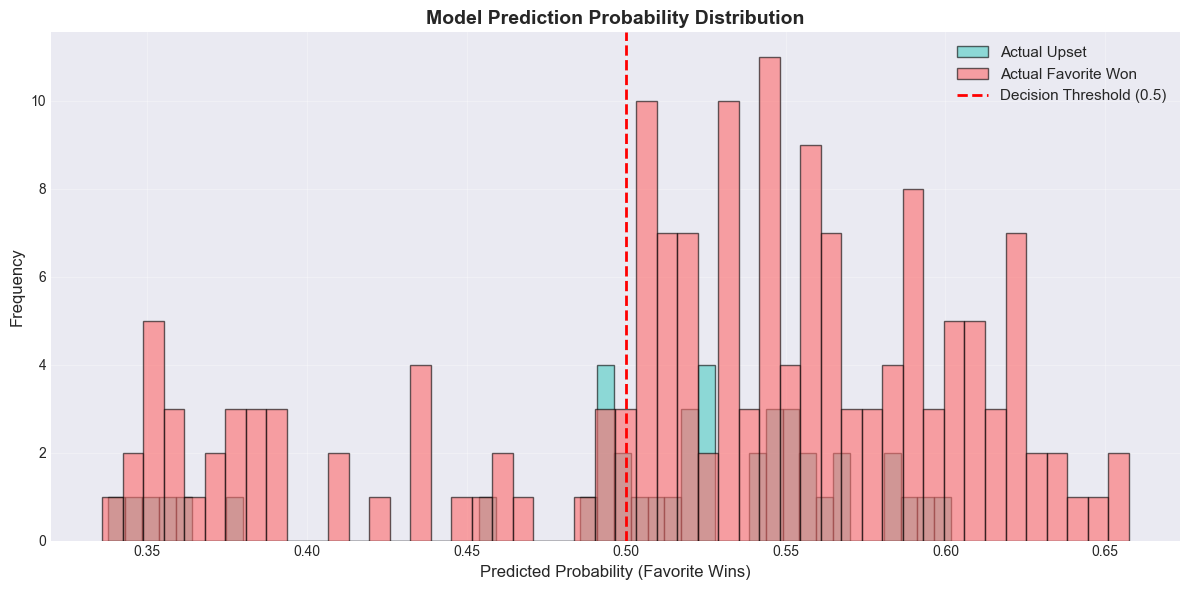


Prediction Probability Statistics:
Mean prediction for upset cases: 0.509
Mean prediction for favorite wins: 0.523
Standard deviation of all predictions: 0.079


In [14]:
# Distribution of model's predicted probabilities
fig, ax = plt.subplots(figsize=(12, 6))

# Separate histograms for actual upsets and actual favorite wins
ax.hist(proba_test[y_test == 0], bins=50, alpha=0.6, label='Actual Upset', color='#4ECDC4', edgecolor='black')
ax.hist(proba_test[y_test == 1], bins=50, alpha=0.6, label='Actual Favorite Won', color='#FF6B6B', edgecolor='black')

# Threshold line
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')

ax.set_xlabel('Predicted Probability (Favorite Wins)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Model Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"\nPrediction Probability Statistics:")
print(f"Mean prediction for upset cases: {proba_test[y_test == 0].mean():.3f}")
print(f"Mean prediction for favorite wins: {proba_test[y_test == 1].mean():.3f}")
print(f"Standard deviation of all predictions: {proba_test.std():.3f}")

### 7.7 Calibration Plot

Shows how well the model's predicted probabilities align with actual probabilities.

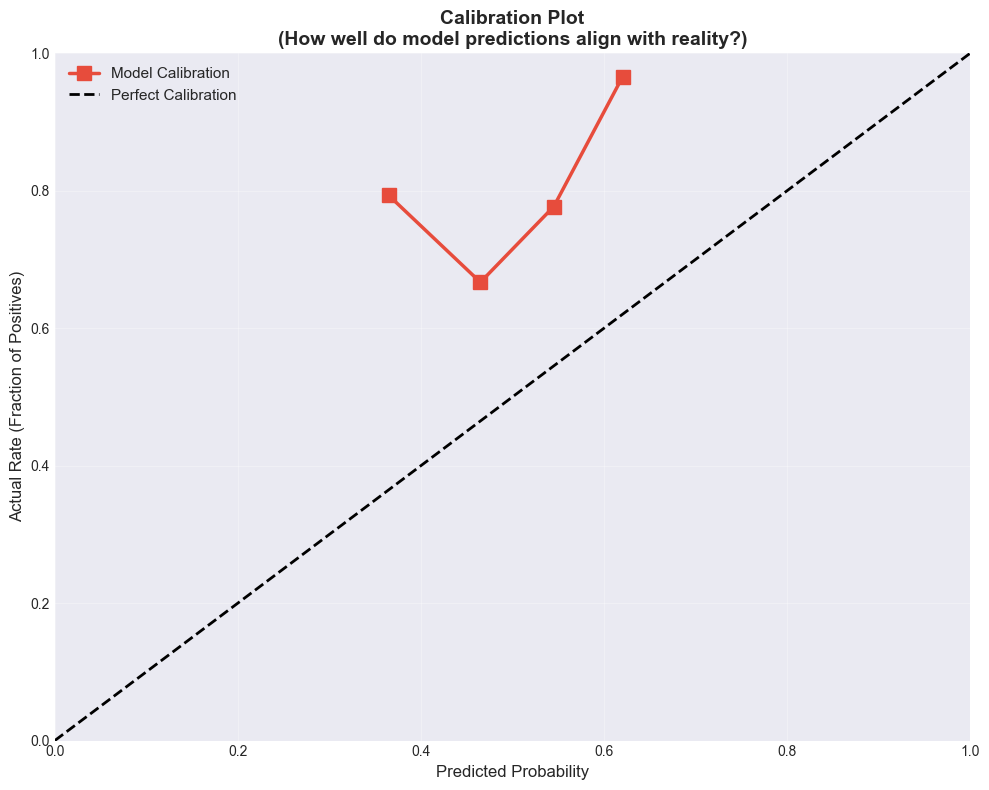


Calibration Interpretation:
- Line close to dashed line → Model is well calibrated
- Line above dashed line → Model is overconfident
- Line below dashed line → Model is underconfident


In [15]:
# Calibration plot: Predicted vs actual probabilities
from sklearn.calibration import calibration_curve

fig, ax = plt.subplots(figsize=(10, 8))

# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, proba_test, n_bins=10)

# Plot
ax.plot(mean_predicted_value, fraction_of_positives, 's-', linewidth=2.5, markersize=10, 
        color='#e74c3c', label='Model Calibration')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Actual Rate (Fraction of Positives)', fontsize=12)
ax.set_title('Calibration Plot\n(How well do model predictions align with reality?)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"\nCalibration Interpretation:")
print("- Line close to dashed line → Model is well calibrated")
print("- Line above dashed line → Model is overconfident")
print("- Line below dashed line → Model is underconfident")

## 8. Saving Results

In [16]:
# Save results to file
reports_dir = "/Users/boraberkercansever/Desktop/DSA210/reports"
os.makedirs(reports_dir, exist_ok=True)
out_path = os.path.join(reports_dir, "baseline_upset_model_metrics.txt")

with open(out_path, "w", encoding="utf-8") as f:
    f.write("Baseline Upset Model Metrics\n")
    f.write("="*40 + "\n")
    for k, v in metrics.items():
        f.write(f"{k}: {v}\n")
        
print(f"\nMetrics saved to: {out_path}")


Metrics saved to: /Users/boraberkercansever/Desktop/DSA210/reports/baseline_upset_model_metrics.txt


## 9. Feature Inspection (Optional)

To inspect the created features:

In [17]:
# Inspect features
print("\nFeature columns:")
print(X.columns.tolist())

print("\nFirst few rows:")
print(X.head())

print("\nBasic statistics:")
print(X.describe())


Feature columns:
['pFav_open', 'pFav_close', 'delta_pFav', 'overround_open', 'overround_close', 'lg_FRANCE', 'lg_GERMANY', 'lg_ITALY', 'lg_SPAIN']

First few rows:
   pFav_open  pFav_close  delta_pFav  overround_open  overround_close  \
0   0.754014    0.753735   -0.000278        0.052568         0.054715   
1   0.742669    0.735495   -0.007175        0.051948         0.057501   
2   0.844062    0.845664    0.001602        0.048448         0.057128   
3   0.830079    0.834813    0.004734        0.056759         0.057818   
4   0.858315    0.866375    0.008060        0.049615         0.055445   

   lg_FRANCE  lg_GERMANY  lg_ITALY  lg_SPAIN  
0      False        True     False     False  
1      False        True     False     False  
2      False        True     False     False  
3      False        True     False     False  
4      False        True     False     False  

Basic statistics:
        pFav_open  pFav_close  delta_pFav  overround_open  overround_close
count  811.000000  8